In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
import scipy

In [5]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [6]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [7]:
from src.utils import get_stars

# load data

In [8]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)

topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [9]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY',
        'pi_exp_MY', 'i_exp_MY', 'pi_exp_WY', 'riskaversion'
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[
    ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
].drop_duplicates().add_suffix("_F"),],
                 index_name='date_recorded')

In [10]:
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [11]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()
df = df.reset_index(drop=True)

In [12]:
# check

In [13]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

## plot time series inflation

In [14]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_de_Y', 'pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_de_estimate_Y', 'pi_exp_MY_F'], 'M', 'last').dropna()

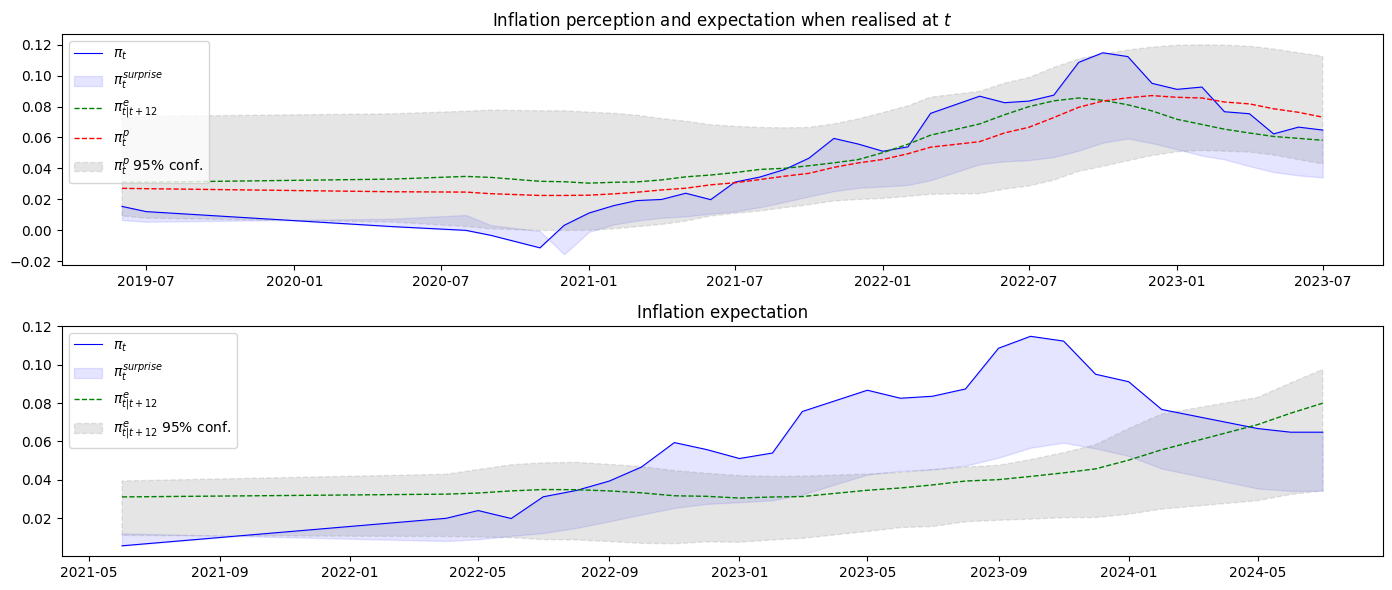

In [15]:
fig, ax = plt.subplots(2,1, figsize=(14,6))

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax[0].set_title('Inflation perception and expectation when realised at $t$', size=12)
ax[0].legend(loc='upper left', )

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^e_{t|t+12}$ 95% conf.')
ax[1].set_title("Inflation expectation", size=12)
ax[1].legend()

fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

# Cross Section Expectation and perception

In [16]:
# get pi percption error
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)
df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [17]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols

['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

In [18]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (10748, 2)
pi_exp_MY_error_act (10976, 2)
pi_perc_MY_error_act (9130, 2)


In [19]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\pi^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\pi^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\pi^p_{t}$"
}

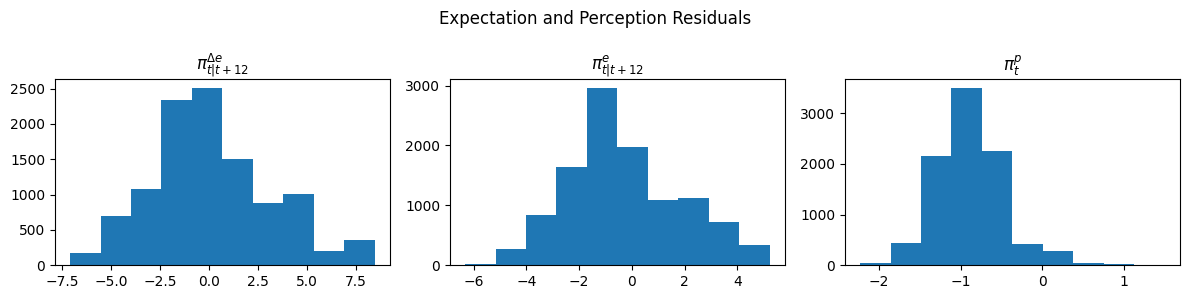

In [20]:
fig, axes = plt.subplots(1,3,)
for i, ax in enumerate(axes.ravel()):
    ax.set_title(lst_error_cols[i], size=10)
    ax.hist(df[['id', lst_error_cols[i]]].drop_duplicates().drop('id', axis=1).dropna(), )
    ax.set_title(dict_cols_pretty_names[lst_error_cols[i]])
    
fig.suptitle("Expectation and Perception Residuals")
fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')

In [21]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'eduwork_txt',
        # 'wealth_bank_midpoint', 
        # 'savings_planned', 
        'profession_txt',
        # 'ecbtrust',
        # 'pr
        'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [22]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': 'categoryO', 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO'
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [23]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col], dtype=bool)
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [24]:
# multiple ols models
lst_ols_mods = []
for col in lst_error_cols:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    d = d.dropna()
    print(d.shape)
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    lst_ols_mods.append(ols)

(3282, 45)
(3397, 45)
(2568, 45)


In [25]:
_ = get_statsmodels_summary(lst_ols_mods, seperator=" ", is_filt_sig=True)
save_pd_df(_, 'tab_cross_section_error.csv', GRAPHS_DIR)

In [26]:
_

,delta_pe_MY_error_act,pi_exp_MY_error_act,pi_perc_MY_error_act
is_food_shop,-0.174 [-0.848],0.019 [0.137],0.102 ** [2.474]
hhinc_midpoint2250.0,0.687 * [1.831],0.545 ** [2.086],-0.015 [-0.199]
hhsize2.0,-0.0 *** [-3.043],0.0 [0.157],0.0 [0.812]
riskaversion1.0,-0.483 [-0.417],0.332 [0.407],0.497 ** [2.381]
riskaversion3.0,1.086 *** [3.048],0.835 *** [3.451],0.022 [0.296]
riskaversion4.0,0.306 [1.041],0.51 ** [2.539],-0.012 [-0.212]
riskaversion5.0,0.53 ** [2.357],0.634 *** [4.049],0.044 [0.979]
riskaversion6.0,0.321 [1.261],0.568 *** [3.248],0.053 [1.049]
riskaversion7.0,0.633 *** [3.104],0.768 *** [5.373],0.075 * [1.892]
riskaversion8.0,0.997 *** [3.976],0.921 *** [5.308],-0.025 [-0.516]


## risk aversion delta_pe

In [27]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]

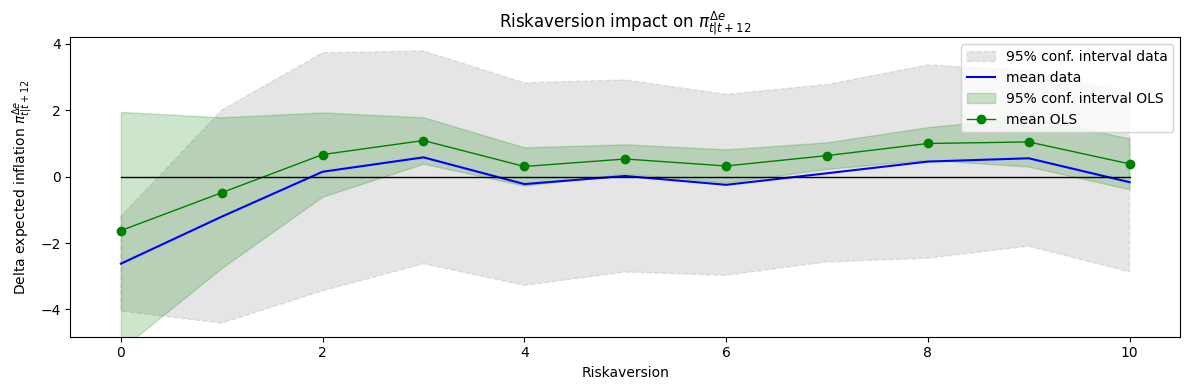

In [28]:
sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.fill_between(sub.index, sub['mean'] - 1.2 *  sub['std'], sub['mean'] + 1.2 *  sub['std'], alpha=.2, color='grey', 
                 label='95% conf. interval data', linestyle='dashed')
ax.plot(sub['mean'], color='blue', label='mean data')
y_lim = ax.get_ylim()

ax.fill_between(sub.index, sub2['conf_lower'], sub2['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub2['coef'].values, lw=1, marker='o', color='green', label='mean OLS')
ax.plot(sub.index, list([0] * len(sub2)), color='black', lw=1)

ax.set_ylim(y_lim)

ax.legend()
ax.set_xlabel("Riskaversion")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\pi^{\Delta e}_{t|t+12}$")

fig.tight_layout()
save_fig(fig, "riskaversion.png", GRAPHS_DIR)

# Macro Time Series Error analysis

## Test errors in time series dimension

In [29]:
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [30]:
arr = df.set_index('date_recorded').delta_pe_MY_error_act_WY.drop_duplicates().values 
arr = df.set_index('date_recorded').pi_perc_MY_all_error_act_WY.drop_duplicates().values 

In [31]:
arr = np.random.randn(100) / 100
arr1 = np.random.randn(100) / 100

In [32]:
# cross_corr(arr, arr1, lags=10);

## VECM error, perceived and expexcted

### pi perc

In [33]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()

In [34]:
cols_endog, cols_exog = ['pi_perc_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
# print(var1.summary())

In [35]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=3).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.018553484289268035
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [36]:
# vecm1.irf(periods=5).plot()
# plt.tight_layout()
# ;

### pi perc error

In [37]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY_all_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [38]:
cols_endog, cols_exog = ['pi_perc_MY_all_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var2 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2, ic='fpe')
# print(var1.summary())

In [39]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 7) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=3).fit()
# vecm2.summary()

pi_perc_MY_all_error_act_MY ADF p-val: 0.09312812377193597
pi_de_surprise_Y ADF p-val: 0.3017349697248496
pi_de_estimate_Y ADF p-val: 0.7825207762316098
2
6 2


### delta exp

In [40]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [41]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=5).fit()
# vecm3.summary()

delta_pe_MY ADF p-val: 0.44313200381795326
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [42]:
# vecm3.irf().plot()
# plt.tight_layout();

### delta exp error

In [43]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [44]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=4).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.9509824412702439
pi_de_surprise_Y ADF p-val: 0.0535354526734725
pi_de_estimate_Y ADF p-val: 0.8029480317761679
2
5 1


### uncertainty

In [45]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_uncertainty_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [46]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=3).fit()
# vecm5.summary()

pi_perc_uncertainty_MY ADF p-val: 0.0006861008216353449
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
1
5 1


In [47]:
# vecm5.irf().plot()
# plt.tight_layout();

### summary

In [48]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4, vecm5]
out = get_statsmodels_summary(lst_vecms, is_filt_sig=True)
save_pd_df(out, 'tab_vecm_resid.csv', GRAPHS_DIR)

In [49]:
out

,delta_pe_MY,delta_pe_MY_error_act_MY,pi_perc_MY,pi_perc_MY_all_error_act_MY,pi_perc_uncertainty_MY
L1.pi_perc_MY,NaN,NaN,0.414 **\n[2.031],NaN,NaN
L1.pi_de_surprise_Y,0.782 ***\n[3.277],1.552 **\n[2.027],0.147 **\n[2.241],0.242 \n[0.982],-0.011 \n[-0.106]
L1.pi_de_estimate_Y,0.337 \n[0.996],-0.243 \n[-0.22],0.37 ***\n[3.153],-0.814 ***\n[-4.955],-0.059 \n[-0.451]
L2.pi_de_surprise_Y,0.646 ***\n[2.995],1.365 **\n[2.009],0.052 \n[0.94],0.243 \n[1.166],-0.005 \n[-0.063]
L3.pi_de_surprise_Y,0.384 **\n[2.291],0.999 \n[1.526],0.022 \n[0.559],0.219 \n[1.515],-0.014 \n[-0.289]
L3.pi_de_estimate_Y,-0.753 **\n[-2.223],1.445 *\n[1.919],0.287 ***\n[2.589],0.513 **\n[2.537],0.103 \n[0.988]
N lags,6.0,5.0,4.0,4.0,4.0
L3.pi_perc_MY_all_error_act_MY,NaN,NaN,NaN,-0.322 **\n[-2.314],NaN
L1.delta_pe_MY,1.055 ***\n[5.37],NaN,NaN,NaN,NaN
L4.pi_de_surprise_Y,0.312 ***\n[2.627],-0.12 \n[-0.23],NaN,NaN,NaN


In [ ]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "delta_pe_MY_error_act_MY": '$\pi^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",},
                            figsize=(5,3));
save_fig(fig, "emp_erro_vecm.png")

## VECM error, news, perceived and expexcted

### overview on news and narratives

In [226]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

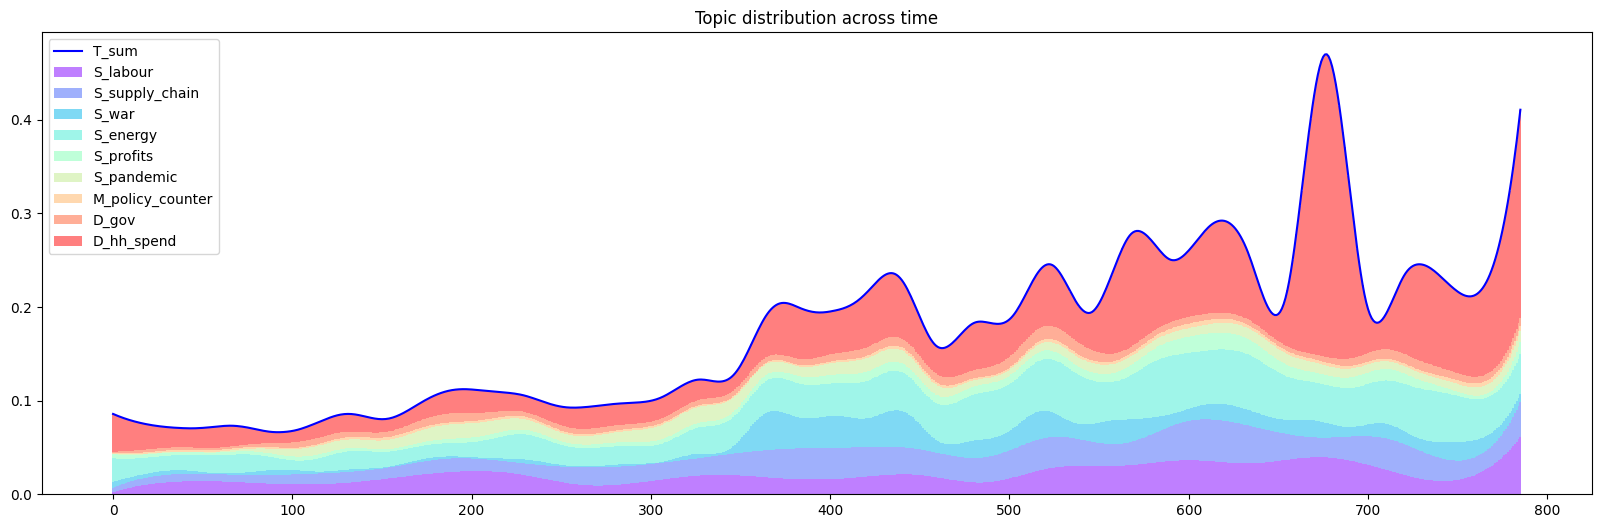

In [56]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
# ax.twinx().plot(sub.D_inflation.values, color='green', label='D_inflation')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left");
save_fig(fig, "topics_time.png")

''

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


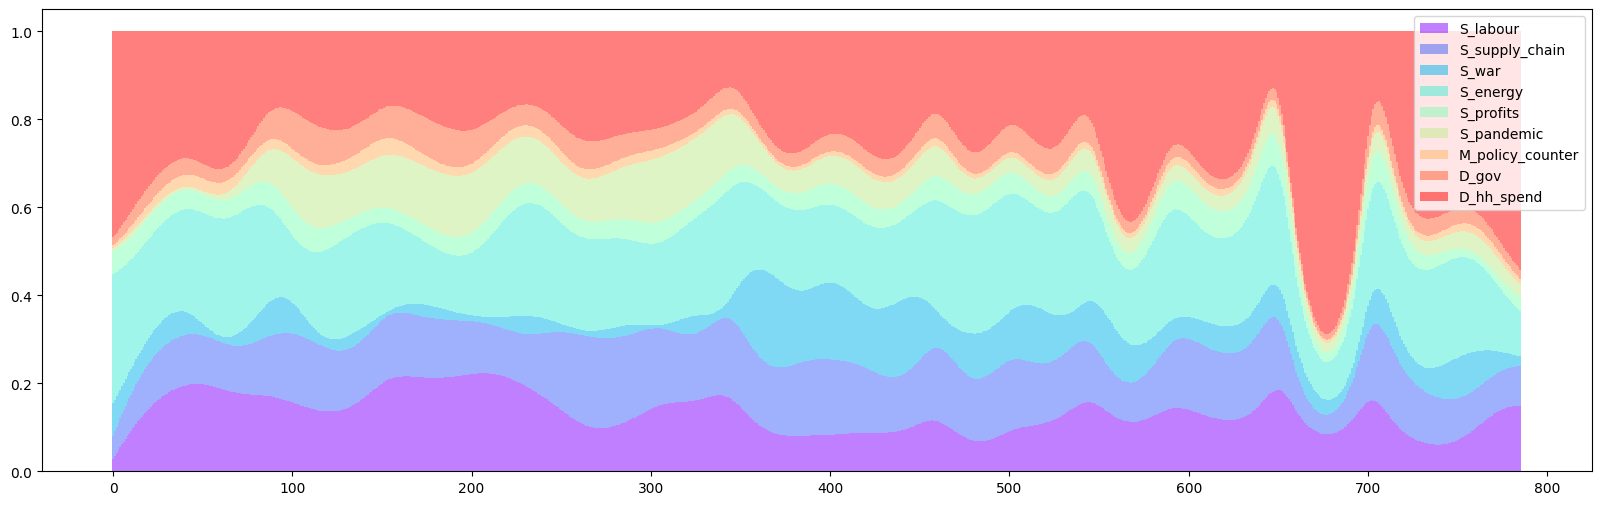

In [57]:
fig, ax = plt_stacked_bar(
    sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
)
ax.legend()
;

### war and inflation as given by hh concern

In [437]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']

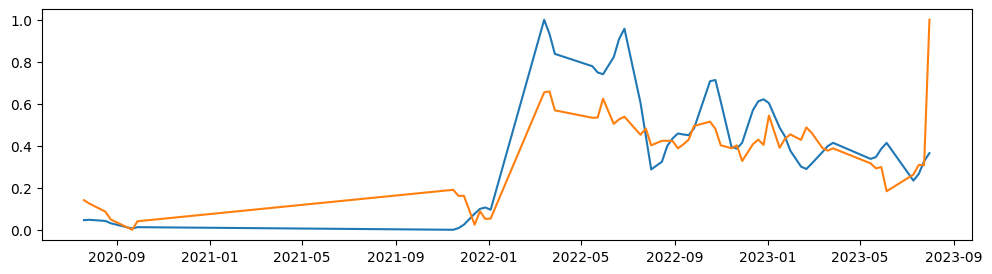

In [59]:
plt.plot(sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x)))
sub[cols_endog + cols_exog] = sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x))

In [60]:
var = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2)
# print(var.summary())

## pi perc

In [438]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',
                  'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
# sub.plot();
sub.shape

(34, 9)

In [439]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
3
2 0


In [440]:
# vecm1.irf().plot()
# plt.tight_layout();

## pi perc error

In [441]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY_error_act ADF p-val: 7.217927277626793e-08
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


## delta pe

In [442]:
cols_endog, cols_exog = ['delta_pe_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY',]

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_perc_MY ADF p-val: 0.01874377846322591
3
2 0


## delta pe error

In [443]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY_error_act_MY ADF p-val: 0.020658890361074964
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
2
2 0


## uncertainty

In [444]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_uncertainty_MY ADF p-val: 0.0009126750943224087
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
2
2 0


## summary

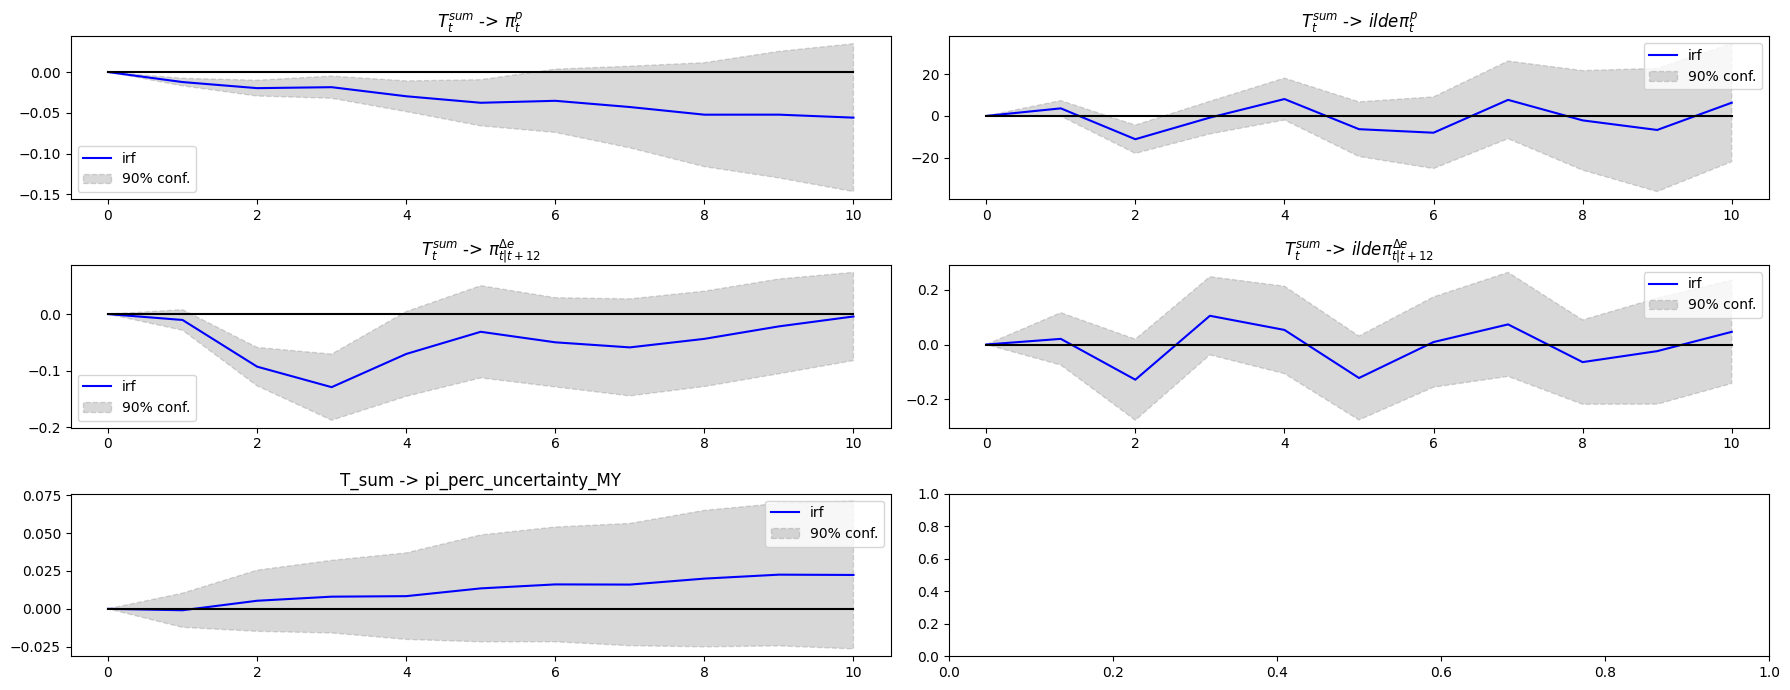

In [445]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4, vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\tilde{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",
                                         });
save_fig(fig, "emp_vecm_error_news.png")

In [446]:
out = get_statsmodels_summary(lst_vecms, is_filt_sig=True)
save_pd_df(out, 'tab_vecm_news_resid.csv', GRAPHS_DIR)

## without inflation

In [447]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'pi_perc_uncertainty_WY', 
                                   'delta_pe_WY', 'pi_perc_MY_all_error_act_WY', 'pi_perc_WY', 'T_sum']].last().dropna()
sub.shape

(91, 6)

In [448]:
cols_endog, cols_exog = ['pi_perc_uncertainty_WY'], ['T_sum', 'pi_perc_WY', 'delta_pe_WY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_uncertainty_WY ADF p-val: 5.592176077492414e-06
T_sum ADF p-val: 0.9713187460871008
pi_perc_WY ADF p-val: 0.01849634003386648
delta_pe_WY ADF p-val: 0.8976540313298764
3
3 1


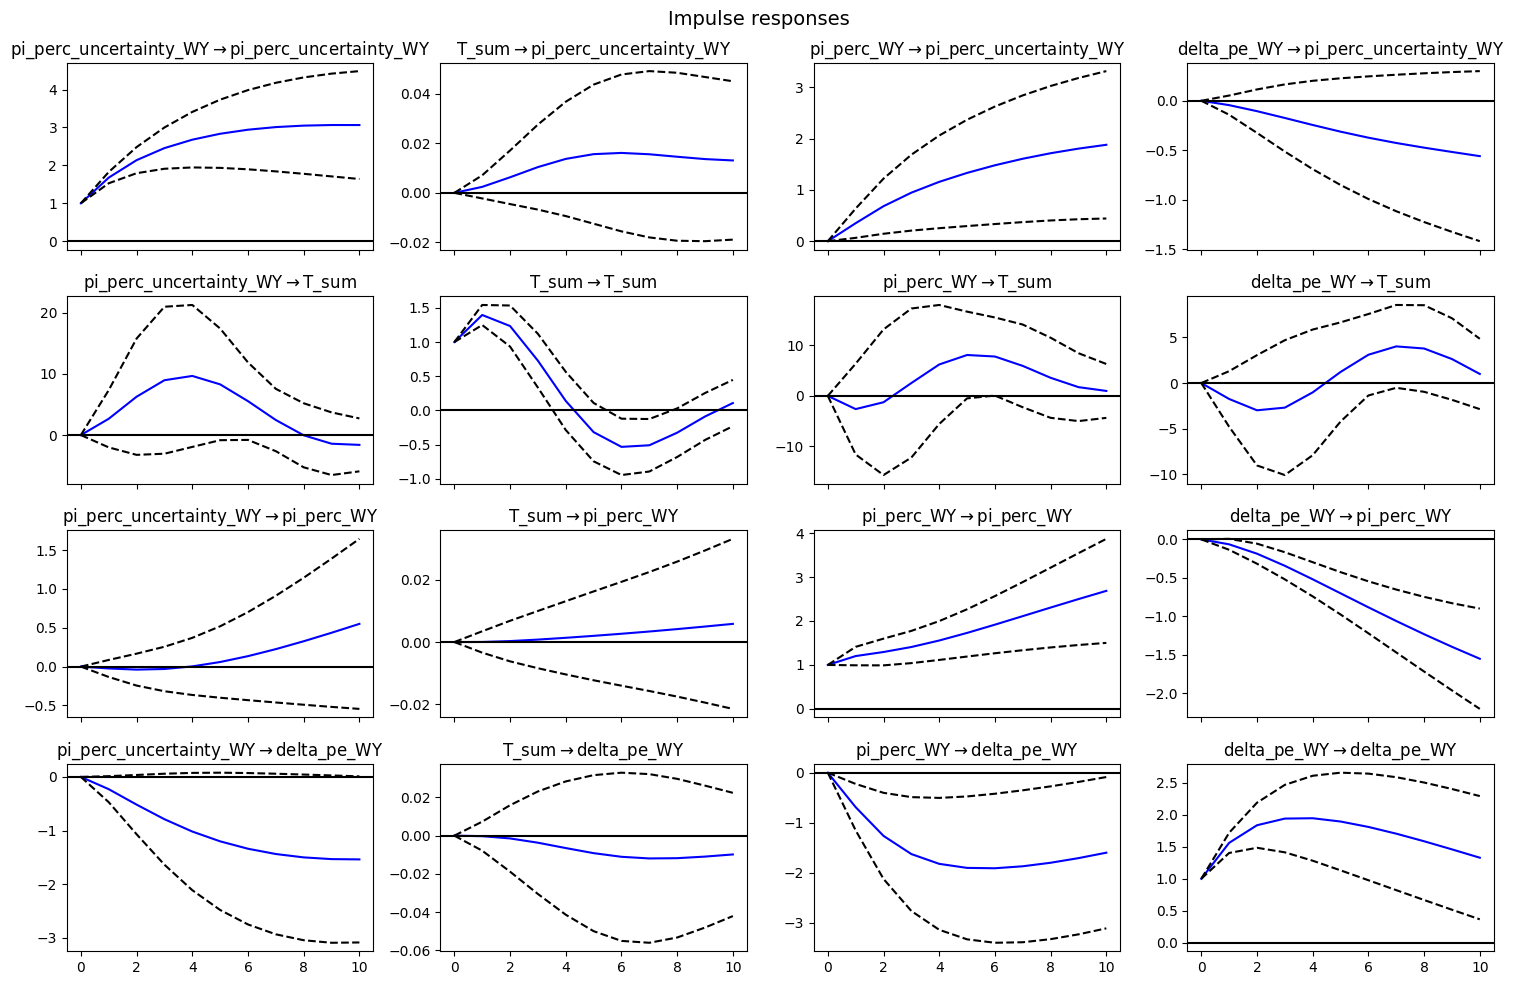

In [449]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

## FECVD

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [75]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 [ 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [76]:
var = VAR(sub).fit(ic='aic')
# var.summary()

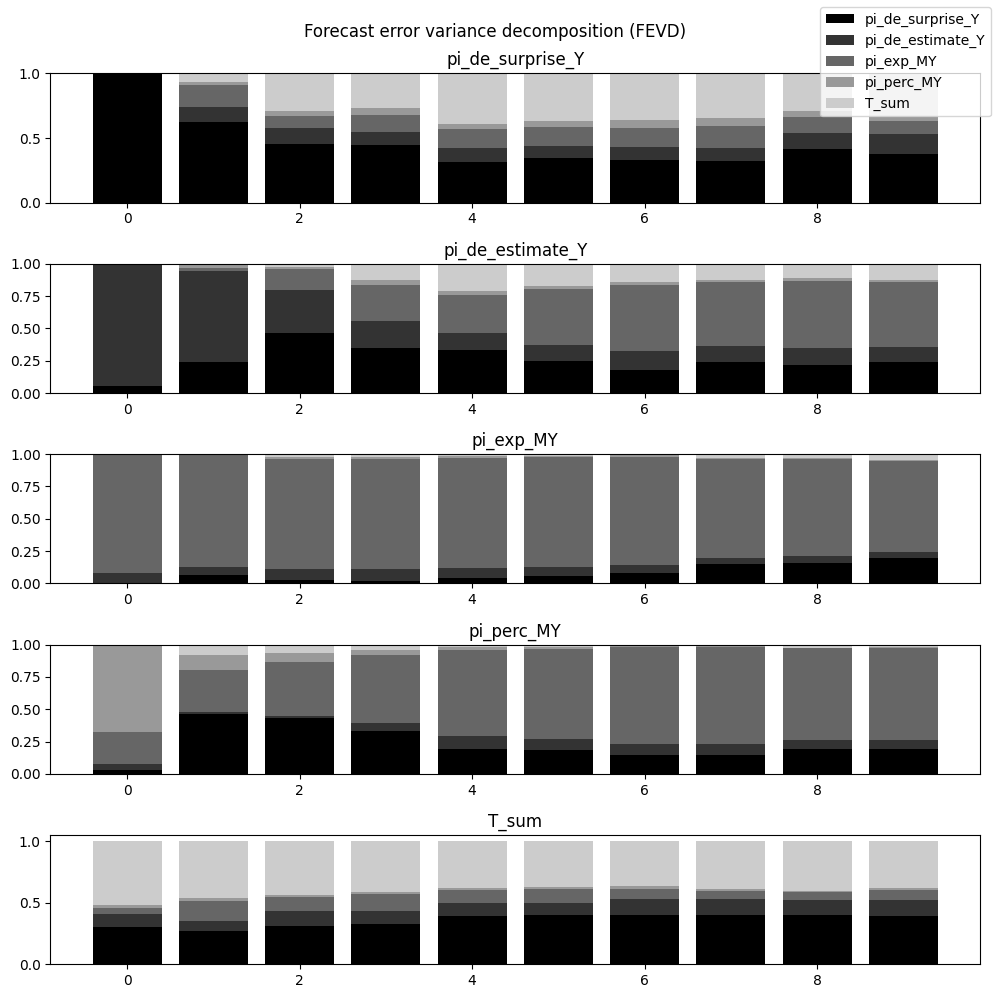

In [77]:
var.fevd().plot()
plt.tight_layout();

# Micro analysis

In [78]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [79]:
df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

In [80]:
_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [81]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
    }
)

In [82]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [83]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [84]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

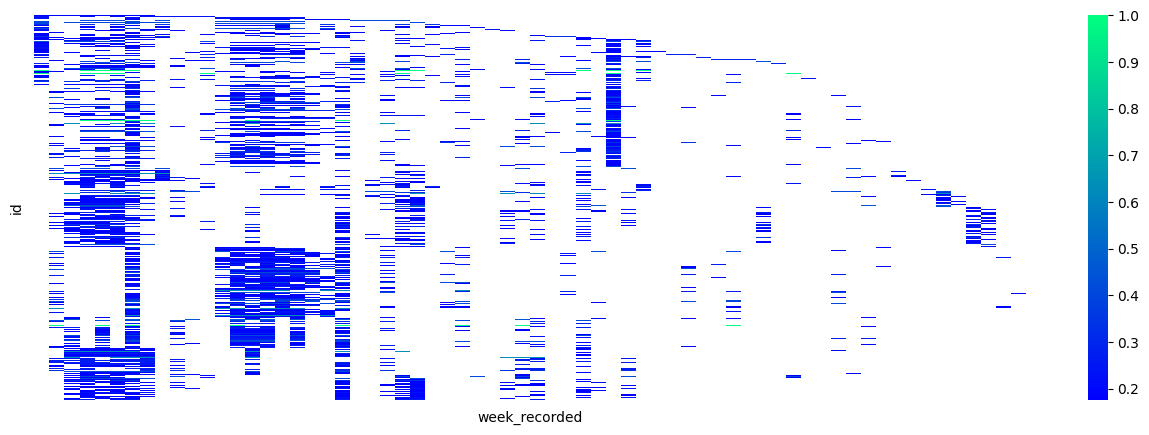

In [85]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [150]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'is_unempl',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [151]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2960, 6), 473)

In [154]:
m_fe1 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe1)

In [155]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [156]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe1.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 9.823345468786036, 'LM p-val': 0.08039824060326989, 'F-Stat': 1.9672152493122284, 'F p-val': 0.08035681028655561}


In [157]:
durbin_watson_test_results = durbin_watson(m_fe1.resids) 
print(durbin_watson_test_results)

2.003189144921536


In [158]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe1, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 14.600276284910336
degrees of freedom: 16
p-Value: 0.5540861565461142


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [159]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [160]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 8), 715)

In [162]:
m_fe2 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
# print(m_fe2)

In [163]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe2.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 39.265752244144366, 'LM p-val': 1.7390498016438214e-06, 'F-Stat': 5.668991456943702, 'F p-val': 1.601150959697881e-06}


In [164]:
durbin_watson_test_results = durbin_watson(m_fe2.resids) 
print(durbin_watson_test_results)

2.3904795244702512


In [165]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe2, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 40.959476184847546
degrees of freedom: 34
p-Value: 0.19158490972166012


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [168]:
# cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [169]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 5), 4300)

In [170]:
m_fe3 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe3)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4441
Estimator:                   PanelOLS   R-squared (Between):              0.8085
No. Observations:               29619   R-squared (Within):               0.4441
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.7650
Time:                        16:22:43   Log-likelihood                 7.763e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1347.6
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                F(15,25304)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             756.25
                            

In [171]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe3.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 133.1404813122156, 'LM p-val': 8.292152676129695e-28, 'F-Stat': 33.429771744325556, 'F p-val': 7.216257104948309e-28}


In [172]:
durbin_watson_test_results = durbin_watson(m_fe3.resids) 
print(durbin_watson_test_results)

1.9855357494078825


In [173]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe3, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 52.86253519725508
degrees of freedom: 15
p-Value: 4.064255864159783e-06


## Exp 4

In [175]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [176]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [177]:
m_fe4 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe4)

                          PanelOLS Estimation Summary                           
Dep. Variable:          pi_perc_error   R-squared:                        0.4424
Estimator:                   PanelOLS   R-squared (Between):             -2.6228
No. Observations:                8055   R-squared (Within):               0.4424
Date:                Thu, Apr 04 2024   R-squared (Overall):             -0.3086
Time:                        16:23:02   Log-likelihood                 2.089e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      346.31
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(15,6548)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             300.06
                            

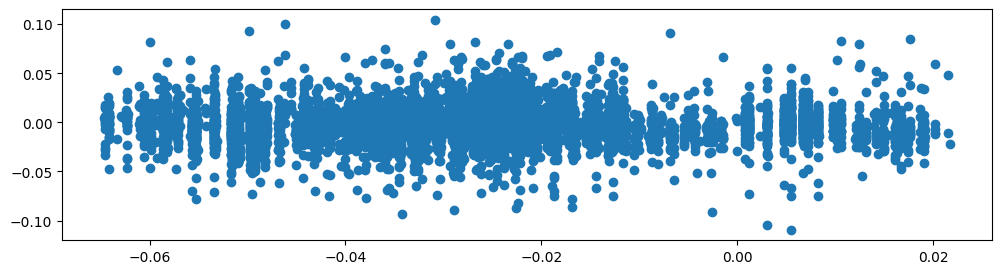

In [178]:
plt.scatter(m_fe4.predict().values, m_fe4.resids.values)

In [179]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe4.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 52.03673808657077, 'LM p-val': 1.3552675060327403e-10, 'F-Stat': 13.085644900759641, 'F p-val': 1.2651597417107182e-10}


In [180]:
durbin_watson_test_results = durbin_watson(m_fe4.resids) 
print(durbin_watson_test_results)

2.1858898499137123


In [181]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe4, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 18.942788845803136
degrees of freedom: 15
p-Value: 0.21633813221827905


## Exp 5

In [193]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_surprise_Y', 'pi_de_estimate_Y', ] #'debt', 'is_unempl', 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [194]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((45794, 5), 7279)

In [195]:
sub = sub.loc[~sub.duplicated()]

In [196]:
m_fe5 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe5)

                          PanelOLS Estimation Summary                           
Dep. Variable:         delta_pe_error   R-squared:                        0.8657
Estimator:                   PanelOLS   R-squared (Between):              0.9789
No. Observations:                2872   R-squared (Within):               0.8657
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.9744
Time:                        16:44:34   Log-likelihood                 1.004e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      513.74
Entities:                        1662   P-value                           0.0000
Avg Obs:                       1.7280   Distribution:                 F(15,1195)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             640.85
                            

In [197]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [198]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe5.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 40.99363922653696, 'LM p-val': 2.6959917417904623e-08, 'F-Stat': 10.378708901096479, 'F p-val': 2.4069431527683775e-08}


In [199]:
durbin_watson_test_results = durbin_watson(m_fe5.resids) 
print(durbin_watson_test_results)

2.3766729333471246


In [200]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe5, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 60.80311569891607
degrees of freedom: 15
p-Value: 1.8342627123174704e-07


## summary

In [504]:
lst_fes = [m_fe1, m_fe2, m_fe3, m_fe4, m_fe5]
_ = get_statsmodels_summary(lst_fes, seperator=" ", is_filt_sig=True)
save_pd_df(_, 'tab_pols.csv', GRAPHS_DIR)

In [505]:
_

,delta_pe,delta_pe_error,pi_exp,pi_perc,pi_perc_error
T_sum_diff_lag,2.193 *** [38.343],0.165 ** [2.171],-0.203 *** [-6.947],-0.297 *** [-3.99],-0.09 * [-1.77]
hhinc_midpoint.1250.0,0.009 ** [2.403],-0.002 [-0.466],-0.002 [-0.441],-0.001 [-0.098],-0.002 [-0.237]
hhinc_midpoint.1750.0,0.008 ** [2.303],0.001 [0.355],-0.002 [-0.57],-0.009 [-0.611],-0.002 [-0.197]
hhinc_midpoint.2250.0,0.008 ** [2.289],0.003 [0.686],-0.003 [-0.803],-0.01 [-0.673],-0.0 [-0.012]
hhinc_midpoint.2750.0,0.009 ** [2.401],0.003 [0.891],-0.003 [-0.818],-0.006 [-0.441],0.002 [0.164]
hhinc_midpoint.3250.0,0.011 *** [2.901],0.003 [0.852],-0.003 [-0.704],-0.006 [-0.384],0.004 [0.401]
hhinc_midpoint.3750.0,0.009 ** [2.508],0.003 [0.728],-0.002 [-0.592],-0.004 [-0.276],0.002 [0.23]
hhinc_midpoint.4250.0,0.011 *** [2.9],0.007 [1.521],-0.004 [-0.853],-0.005 [-0.371],0.004 [0.355]
hhinc_midpoint.5500.0,0.01 *** [2.703],0.007 [1.631],-0.003 [-0.817],-0.006 [-0.399],0.005 [0.495]
hhinc_midpoint.7000.0,0.011 *** [2.904],0.007 * [1.745],-0.003 [-0.696],-0.004 [-0.279],0.004 [0.372]
